<a href="https://colab.research.google.com/github/ktongk/BTT-JPMC-1/blob/Katrina/sector10/20_scrape_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [2]:
! pip install --quiet yfinance ##--quiet mutes the package list as it’s installing

In [3]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [4]:
start_date = '2023-03-02'
end_date  = '2023-03-21'

data_dir = '/data/'

#<font color="Grey">**A Timeline on the SVB Crash and why we chose it**

According to Investopedia, SVB Financial Group was removed from the S&P 500 Index due to the collapse its bank. So the most recent rebalancing of S&P 500 was announced on March 10, 2023.

The bank, mostly focused on venture capital funds and small tech startups had a huge boom during the pandemic. The bank then invested all of its profits into low-return bonds. However, after aggressive federal rate hikes the bonds quickly lost their value, causing panic. SVB no longer had the cash to give to the companies withdrawing their money and the FDIC took over the bank.


Initally the FDIC could only insure up to 250k but that wasn't enough, causing fear of a 2008 recession. The fed, treasury, and FDIC then announced a new emergency lending program so every company could get their money back.

##<font color = "green">**Timeseries Length** </font>
Originally, our team was going to do the entire month of march but, because there was a distinct end, it didn't seem necesarry to do the full month. We decided to do a week before SVB announced their losses and then around a week after the emergency lending program was announced.

##<font color = "#D80000"> **What other events did we consider?** </font>



Our team wanted to pick an event that had both positive and negative affects on the S&P500 companies and had a distinct beginning and end (within a reasonably small window).

We considered doing the pandemic but it was too long and the rise of ChatGPT but there were too many factors to consider (3.5 release, 4.0 release, 3.5 gets worse)
See article:

> See article: https://arxiv.org/pdf/2307.09009.pdf

In [5]:
names = ['','SVB announces 1.8 billion loss on bonds', 'SVB shares fall 60%, depositors withdraw money',
         'FDIC takes over SVB only insures up to 250k', 'Fed, Tresury, & FDIC say theyll cover all deposits',
         'Bank stocks bounced back in early trading','',
        ]

dates = ['2023-03-07','2023-03-08', '2023-03-09', '2023-03-10',
             '2023-03-12', '2023-03-14','2023-03-15'
        ]

    # Convert date strings (e.g. 2014-10-18) to datetime
    #import in above cell
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates] #strptime takes in date and format

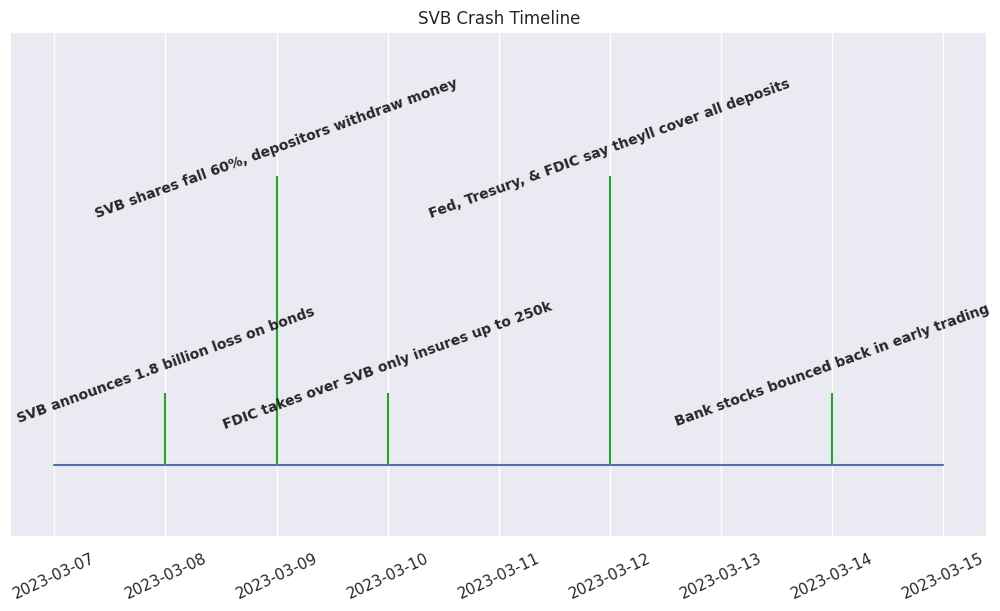

In [6]:
levels = np.tile([0, 1,4, 1, 4,1, 0], int(np.ceil(len(dates)/5)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
ax.set(title="SVB Crash Timeline")

ax.vlines(dates, 0, levels, color="tab:green")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates))  # Baseline and markers on it.



for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l), xytext=(0, 1* 20),# 0 means no horizontal offset and 1*20 means annotation will be 20 spaces from the end of the stem
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="center", rotation=20, fontsize = 10, weight="bold")  # Rotate the text by 45 degrees

ax.set_ylim(-1, 6)
ax.yaxis.set_visible(False)
plt.xticks(rotation=25)
plt.show()

## Google trend search of the keyword "svb"

In [7]:
#svb_google = pd.read_csv('/content/sample_data/svb_google_trend.csv')

#import matplotlib.dates as mdates

In [8]:
'''
svb_google['Day'] = pd.to_datetime(svb_google['Day'])

# Filter the DataFrame to only include dates at a five-day interval
df_filtered = svb_google[svb_google['Day'].dt.day % 1 == 0]

x = df_filtered['Day']
y = df_filtered['SVB: (District of Columbia)']


# Create a DateFormatter object
date_formatter = mdates.DateFormatter('%m-%d')

# Set the DateFormatter as the major formatter for the x-axis
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.plot(x, y)

plt.xlabel('Date')
plt.ylabel('Interest Over Time')

plt.title('Interest over time of "SVB"')

plt.show()'''


'\nsvb_google[\'Day\'] = pd.to_datetime(svb_google[\'Day\'])\n\n# Filter the DataFrame to only include dates at a five-day interval\ndf_filtered = svb_google[svb_google[\'Day\'].dt.day % 1 == 0]\n\nx = df_filtered[\'Day\']\ny = df_filtered[\'SVB: (District of Columbia)\']\n\n\n# Create a DateFormatter object\ndate_formatter = mdates.DateFormatter(\'%m-%d\')\n\n# Set the DateFormatter as the major formatter for the x-axis\nplt.gca().xaxis.set_major_formatter(date_formatter)\n\nplt.plot(x, y)\n\nplt.xlabel(\'Date\')\nplt.ylabel(\'Interest Over Time\')\n\nplt.title(\'Interest over time of "SVB"\')\n\nplt.show()'

## <font color = "990099"> **Get list of companies in S&P500** </font>

Our team will obtain and store the list of the constituents from Wikipedia.

In [9]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
table_industry = data[0]['GICS Sector']
symbols = list(table_symbol.Symbol.values) ##companies
industries = list(table_industry.values) ##Industry Sector

symbols_industries_dict = {}
symbols_industries = data[0].iloc[:, [0,2]].values.tolist()
for pair in symbols_industries:
  keys, values = pair
  symbols_industries_dict[keys] = values

print("{} symbols in total".format(len(symbols)))
print("{} industries in total".format(len(industries)))
print(industries)


503 symbols in total
503 industries in total
['Industrials', 'Industrials', 'Health Care', 'Health Care', 'Information Technology', 'Consumer Staples', 'Information Technology', 'Industrials', 'Utilities', 'Financials', 'Health Care', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Industrials', 'Materials', 'Real Estate', 'Health Care', 'Industrials', 'Utilities', 'Financials', 'Communication Services', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Utilities', 'Industrials', 'Utilities', 'Financials', 'Financials', 'Real Estate', 'Utilities', 'Financials', 'Industrials', 'Health Care', 'Information Technology', 'Information Technology', 'Information Technology', 'Financials', 'Energy', 'Information Technology', 'Information Technology', 'Consumer Discretionary', 'Financials', 'Information Technology', 'Financials', 'Financials', 'Communication Services', 'Utilities', 'Information Technology', 'Consumer

## <font color = "6666FF"> **Download price timeseries** </font>

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [10]:
# Kassi said to get rid of this one because this is the index itself
#symbols.append('SPY')

In [11]:
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2023-03-02--2023-03-21'

In [12]:
'''
try:
  os.mkdir(data_dir)
except:
  print("Dir Error")
  '''
os.makedirs(data_dir, exist_ok=True)


In [13]:
#!ls /data

**Load all the company data files:**

In [14]:
symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-03-02 -> 2023-03-21)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1677733200, endDate = 1679371200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1677733200, endDate = 1679371200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [15]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for ES


,Adj Close,Volume
Date,,
2023-03-02,72.703506,2950700
2023-03-03,73.968338,2863600
2023-03-06,74.213463,1768500
2023-03-07,72.615250,1987800
2023-03-08,73.458481,1896000


## <font color= "CC0099">**Pre-process Financial Timeseries:**

In [16]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the month
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [17]:
# Aggregate all symbols into a price dataframe and volume dataframe
#for each ticker symbol get that csv file, set the index of that to the datetimes
#for each column in df_price is that company's adj price every datetime
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### <font color= "FF6600"> **Removing NaNs**

In [18]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
df_volume.dropna(inplace=True, axis=1)
assert((df_price.index == df_volume.index).all())

In [19]:
True in pd.isna(df_price)

False

### <font color= "FF6600">**Storing the cleaned dataframes**

In [20]:
#so instead of 500 csv files its now two
df_price.to_csv(os.path.join(data_dir, "prices.csv"), index_label='date')
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

#finds percent change between current price and prior
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014497,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015594,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


In [21]:
df_price.pct_change()[1:].to_csv(os.path.join(data_dir, 'prices_pct'+dates+'.csv'), index_label='date')
df_price.to_csv(os.path.join(data_dir, 'prices'+dates+'.csv'), index_label='date')

## <font color= "336699">**Obtain Percentage Change and Correlation**

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from \$100 to \$110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

Spearman correlation

In [22]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### <font color= "336699">**Calculate Correlations**

In [23]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

In [24]:
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518884,0.791646,0.374020,0.633630,0.810016,0.844036,0.907141,0.633080,0.872986,...,0.769743,0.302473,0.665964,0.743984,0.842873,0.723940,0.581283,0.822347,0.232826,0.829997
AAL,0.518884,1.000000,0.363977,-0.151064,0.736561,0.168846,0.642950,0.615690,0.609986,0.667912,...,0.739896,-0.394522,0.452224,0.273453,0.530967,0.064474,0.102182,0.648352,0.545734,0.338240
AAPL,0.791646,0.363977,1.000000,0.431611,0.610113,0.781190,0.553827,0.815994,0.691611,0.642087,...,0.712923,0.532876,0.515754,0.803462,0.644941,0.761709,0.446678,0.716757,0.305478,0.782669
ABBV,0.374020,-0.151064,0.431611,1.000000,0.339879,0.705051,0.322699,0.290112,0.224161,0.327989,...,0.359327,0.294439,0.311519,0.674334,0.404991,0.548516,0.709122,0.218785,0.018604,0.133280
ABNB,0.633630,0.736561,0.610113,0.339879,1.000000,0.482642,0.751249,0.783877,0.845854,0.700263,...,0.805316,-0.174715,0.398855,0.569476,0.545922,0.349104,0.265397,0.693478,0.571563,0.435600


In [25]:
price_corr.loc['TEL'].sort_values(ascending= False)


TEL     1.000000
PNR     0.967170
OTIS    0.955946
MTD     0.955893
VICI    0.946273
          ...   
KR     -0.011052
CHRW   -0.101931
DG     -0.119876
NEM    -0.202647
CHD    -0.276398
Name: TEL, Length: 499, dtype: float64

In [26]:
#sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

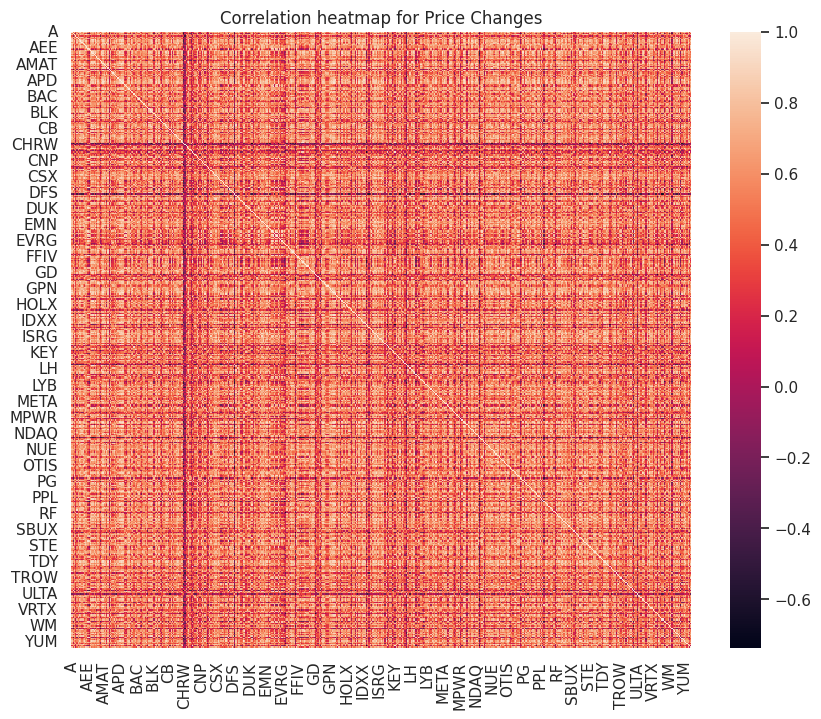

In [27]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### <font color= "9900CC">**Examining correlations further**

In [28]:
df_price_pct['JPM'].head()

2023-03-03    0.018360
2023-03-06   -0.005847
2023-03-07   -0.029408
2023-03-08   -0.005915
2023-03-09   -0.054136
Name: JPM, dtype: float64

Text(0, 0.5, 'GOLD SACH')

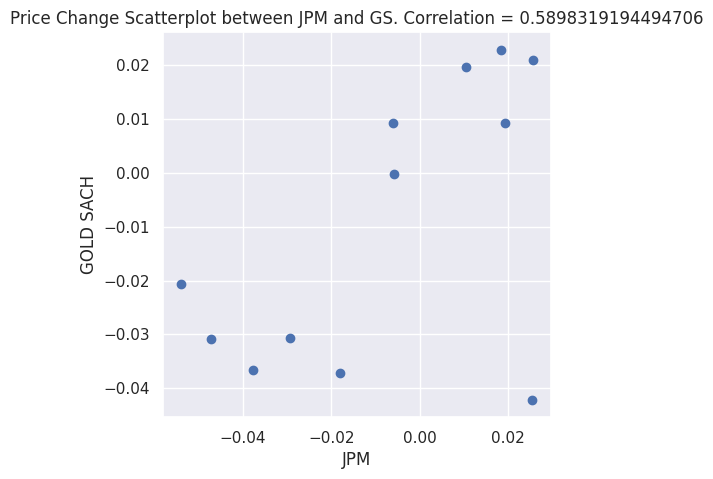

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

plt.xlabel("JPM")
plt.ylabel('GOLD SACH')

Summary statistics for the df_price_pct and df_volume dataframes and then boxplots to find outliers

In [30]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014497,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015594,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


# <font color= "9900CC">Summary Stats and Outliers?
The below box plot is showing the price percentage change averaged across all 500 companies for each day, there's no outliers so it doesn't seem like theres one day in the timeseries where all the companies are all having drastic movement.




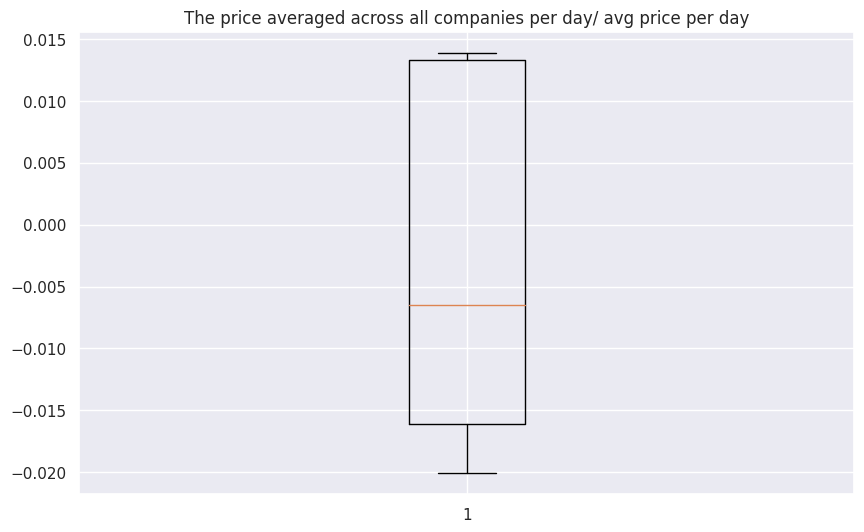

count    12.000000
mean     -0.003676
std       0.014270
min      -0.020058
25%      -0.016112
50%      -0.006525
75%       0.013283
max       0.013898
Name: average, dtype: float64

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
df_price_plotting = df_price_pct
ax.set(title="The price averaged across all companies per day/ avg price per day")
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day



# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

In [32]:

#fig, ax = plt.subplots(figsize=(10, 6))
#ax.set(title="The volume averaged across all companies per day/ avg volume per day")
#df_volume_summary_stats = df_volume.describe()
#df_volume_summary_stats['average'] = df_volume_summary_stats.mean(axis=1)
#df_volume_summary_stats['average']


# Creating plot
#plt.boxplot(df_volume_summary_stats['average']) # plot the volume

# show plot
#plt.show()
#df_volume_summary_stats['average'].describe()

### Analyzng the distributions over time

This time instead of averaging every companies price change per day we're going to look at every company's price change over one day and make a separate boxplot to show the changes in distribution across the week of the crash

on march 2nd there was  3  negative outliers and  13 positive outliers in the distribution
on march 9th there was  21  negative outliers and  3 positive outliers in the distribution
on march 15th there was  9  negative outliers and  14 positive outliers in the distribution
on march 19th there was  10  negative outliers and  10 positive outliers in the distribution




[Text(0.5, 1.0, 'Price % changes on march 19th 2023')]

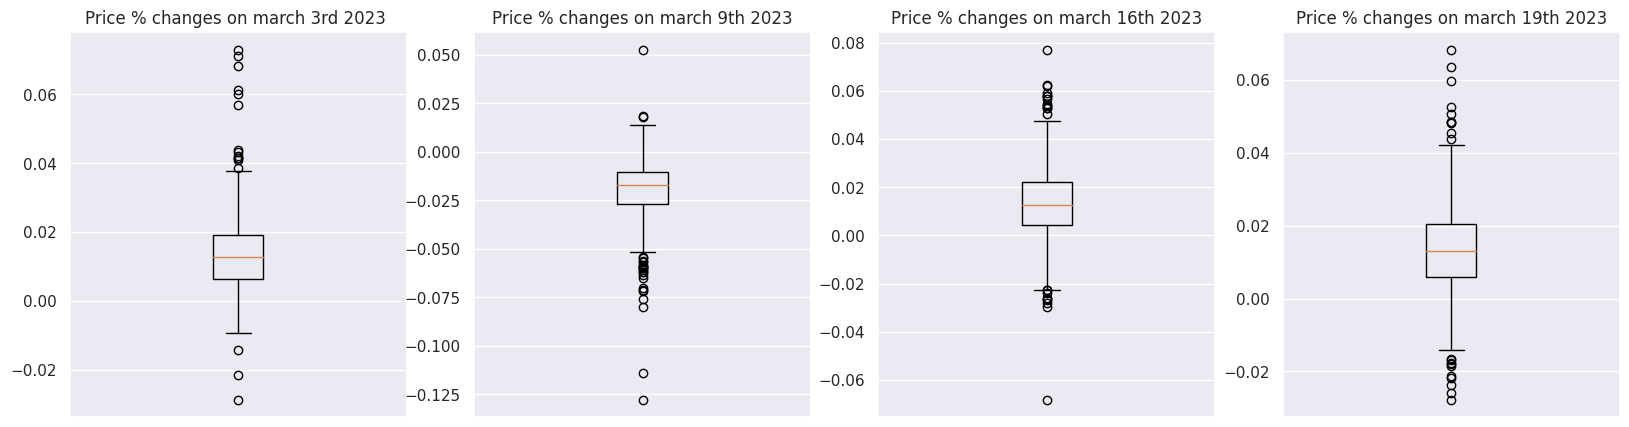

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 5), ncols=4)
bxplt1 = ax1.boxplot(df_price_pct.loc['2023-03-03'])
bxplt2 = ax2.boxplot(df_price_pct.loc['2023-03-09'])
bxplt3 = ax3.boxplot(df_price_pct.loc['2023-03-16'])
bxplt4 = ax4.boxplot(df_price_pct.loc['2023-03-20'])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

outliers1 = bxplt1["fliers"][0].get_ydata()
outliers2 = bxplt2["fliers"][0].get_ydata()
outliers3 = bxplt3['fliers'][0].get_ydata()
outliers4 = bxplt4['fliers'][0].get_ydata()

neg_outliers1 = outliers1[outliers1<0]
neg_outliers2 = outliers2[outliers2<0]


print('on march 2nd there was ', len(neg_outliers1), ' negative outliers and ', len(outliers1[outliers1>0]), 'positive outliers in the distribution')
print('on march 9th there was ', len(neg_outliers2), ' negative outliers and ', len(outliers2[outliers2>0]), 'positive outliers in the distribution')
print('on march 15th there was ', len(outliers3[outliers3<0]), ' negative outliers and ', len(outliers3[outliers3>0]), 'positive outliers in the distribution')
print('on march 19th there was ', len(outliers4[outliers4<0]), ' negative outliers and ', len(outliers4[outliers4<0]), 'positive outliers in the distribution\n\n')

ax1.set(title="Price % changes on march 3rd 2023 ")
ax2.set(title="Price % changes on march 9th 2023")
ax3.set(title= "Price % changes on march 16th 2023")
ax4.set(title = "Price % changes on march 19th 2023")


This is also shown in the line graph showing how during the week of the crash, healthcare company ABT stayed consistent with the monthly trends while financial company charles schwab had one of its lowest price drops. Tesla, a silicon tech company had big drop on the 9th but rebounded pretty quickly

I wanted to show how the crash affects other sectors besides financial

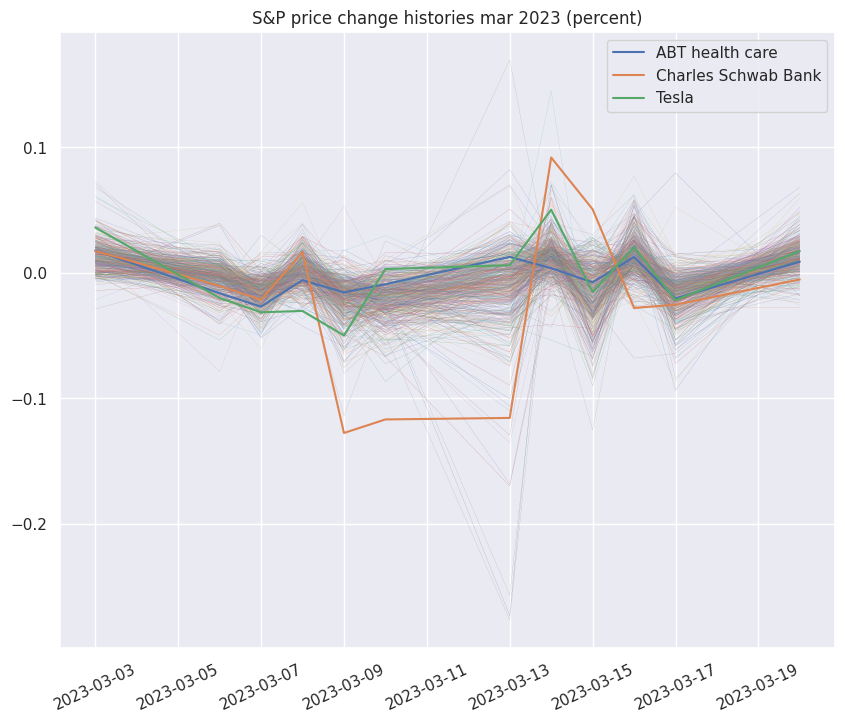

In [34]:
plt.title('S&P price change histories mar 2023 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.plot(df_price_pct['ABT'], label='ABT health care', linewidth=1.5)
plt.plot(df_price_pct['SCHW'], label = 'Charles Schwab Bank', linewidth=1.5)
plt.plot(df_price_pct['TSLA'], label = 'Tesla', linewidth=1.5)
plt.xticks(rotation=25)
plt.legend()

## <font color= "9900CC">**Not every company reacted the same way**
In the original time series used for the file, JPMC and GS's price changes were consistent with each other throughout the month. However, when we set the timeseries to march 2023, during the week of the SVB crash they diverge drastically, this is because while GS suffered due to uncertaintiy w/ the economy, JPMC was in talks to accquire SVB thus their price sky rocketed so you can't definetively say every financial company suffered due to the crash.

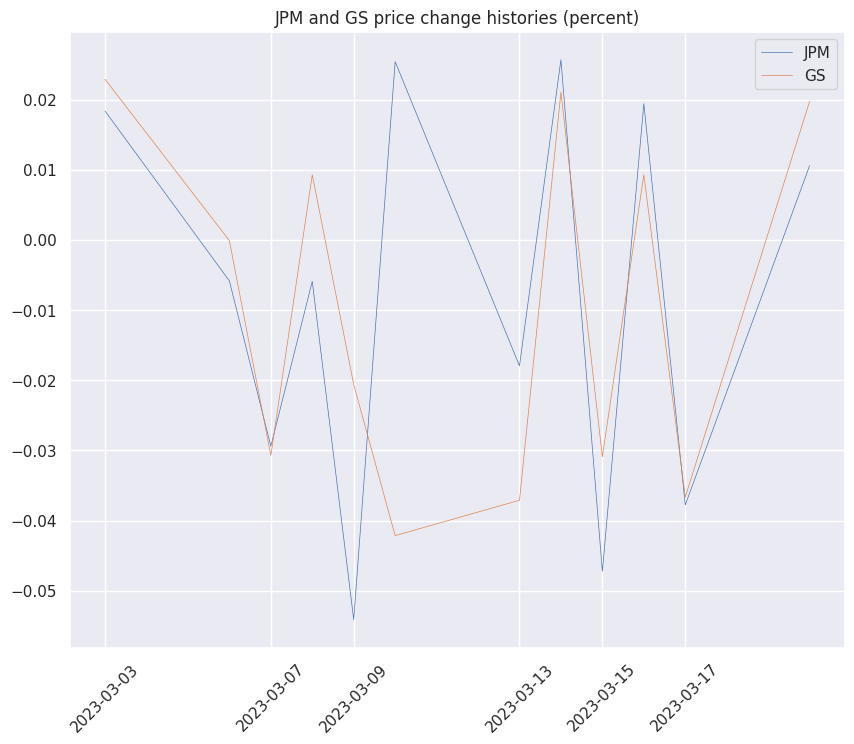

In [35]:
plt.title('JPM and GS price change histories (percent)')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
dates = list(df_price_pct.index.values)
plt.xticks([dates[i] for i in range(len(dates)) if i % 2 == 0], rotation=45)
plt.legend()

In [36]:
df_price_pct_summary_stats = df_price_pct.describe()
df_price_pct_summary_stats['average'] = df_price_pct_summary_stats.mean(axis=1)
print('summary statistics for price (not pct change) averaged across all companies')
#df_price_pct_summary_stats.head()
print(df_price_pct_summary_stats['average'])

summary statistics for price (not pct change) averaged across all companies
count    12.000000
mean     -0.003676
std       0.020243
min      -0.037294
25%      -0.017036
50%      -0.003815
75%       0.009788
max       0.029106
Name: average, dtype: float64


## Saving correlation dataframes

In [37]:
#df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'), index_label='date')
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'), index_label='Symbol')
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))

In [38]:
price_corr

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518884,0.791646,0.374020,0.633630,0.810016,0.844036,0.907141,0.633080,0.872986,...,0.769743,0.302473,0.665964,0.743984,0.842873,0.723940,0.581283,0.822347,0.232826,0.829997
AAL,0.518884,1.000000,0.363977,-0.151064,0.736561,0.168846,0.642950,0.615690,0.609986,0.667912,...,0.739896,-0.394522,0.452224,0.273453,0.530967,0.064474,0.102182,0.648352,0.545734,0.338240
AAPL,0.791646,0.363977,1.000000,0.431611,0.610113,0.781190,0.553827,0.815994,0.691611,0.642087,...,0.712923,0.532876,0.515754,0.803462,0.644941,0.761709,0.446678,0.716757,0.305478,0.782669
ABBV,0.374020,-0.151064,0.431611,1.000000,0.339879,0.705051,0.322699,0.290112,0.224161,0.327989,...,0.359327,0.294439,0.311519,0.674334,0.404991,0.548516,0.709122,0.218785,0.018604,0.133280
ABNB,0.633630,0.736561,0.610113,0.339879,1.000000,0.482642,0.751249,0.783877,0.845854,0.700263,...,0.805316,-0.174715,0.398855,0.569476,0.545922,0.349104,0.265397,0.693478,0.571563,0.435600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.723940,0.064474,0.761709,0.548516,0.349104,0.813976,0.569089,0.692404,0.584596,0.590946,...,0.566738,0.628207,0.454163,0.549112,0.719979,1.000000,0.605333,0.703821,0.322231,0.755966
ZBH,0.581283,0.102182,0.446678,0.709122,0.265397,0.726601,0.468681,0.430972,0.231295,0.453409,...,0.488025,0.171740,0.605129,0.648114,0.712133,0.605333,1.000000,0.356337,0.145916,0.292406
ZBRA,0.822347,0.648352,0.716757,0.218785,0.693478,0.631932,0.762803,0.806577,0.801995,0.913041,...,0.848672,0.262202,0.384179,0.499869,0.725556,0.703821,0.356337,1.000000,0.571482,0.767487
ZION,0.232826,0.545734,0.305478,0.018604,0.571563,0.089373,0.484665,0.416104,0.626160,0.371718,...,0.636502,-0.284169,0.238859,0.086017,0.447630,0.322231,0.145916,0.571482,1.000000,0.086204


# <font color = "333CFF">Creating Graphs

I want to create differnt graphs so this one will be the main one using all the correlation values

## <font color = "6820EE">Heat Maps

In [39]:
symbols_array = np.array(symbols)
symbols_array

array(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG',
       'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT',
       'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS',
       'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL',
       'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIIB', 'BIO',
       'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX',
       'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE',
       'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF',
       'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA',
       'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO',
       'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO',
       'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

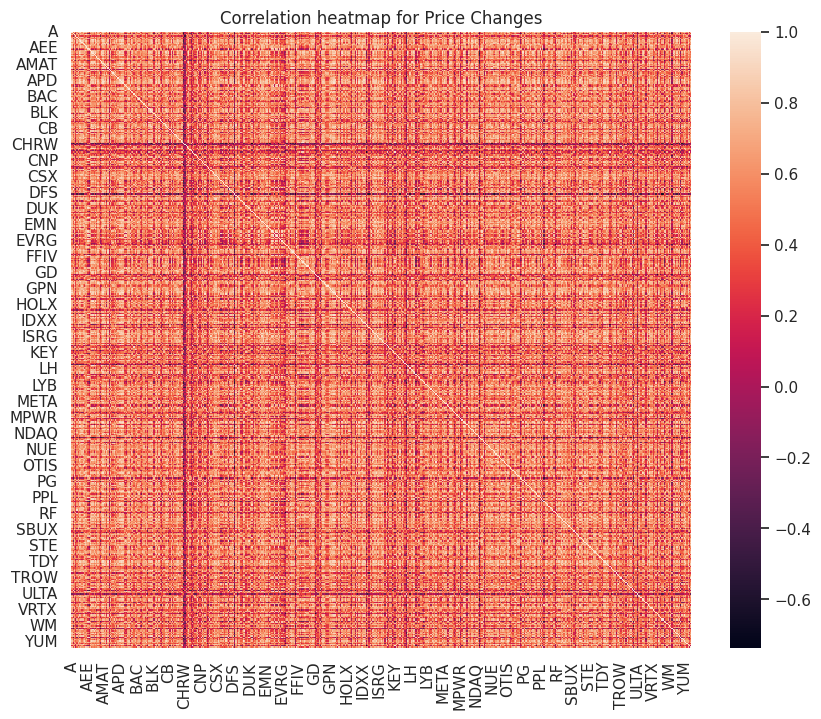

In [40]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

In [41]:
df_industry = pd.DataFrame({"Sectors": industries, "Company": symbols})

In [55]:
unique_sectors = df_industry['Sectors'].unique()
print(unique_sectors)
len(unique_sectors)

['Industrials' 'Health Care' 'Information Technology' 'Consumer Staples'
 'Utilities' 'Financials' 'Consumer Discretionary' 'Materials'
 'Real Estate' 'Communication Services' 'Energy']


11

In [60]:
#creating conditions using a dictionary
sectors_to_append = {sectors: [] for sectors in unique_sectors}
sectors_to_append

{'Industrials': [],
 'Health Care': [],
 'Information Technology': [],
 'Consumer Staples': [],
 'Utilities': [],
 'Financials': [],
 'Consumer Discretionary': [],
 'Materials': [],
 'Real Estate': [],
 'Communication Services': [],
 'Energy': []}

In [78]:
price_corr

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518884,0.791646,0.374020,0.633630,0.810016,0.844036,0.907141,0.633080,0.872986,...,0.769743,0.302473,0.665964,0.743984,0.842873,0.723940,0.581283,0.822347,0.232826,0.829997
AAL,0.518884,1.000000,0.363977,-0.151064,0.736561,0.168846,0.642950,0.615690,0.609986,0.667912,...,0.739896,-0.394522,0.452224,0.273453,0.530967,0.064474,0.102182,0.648352,0.545734,0.338240
AAPL,0.791646,0.363977,1.000000,0.431611,0.610113,0.781190,0.553827,0.815994,0.691611,0.642087,...,0.712923,0.532876,0.515754,0.803462,0.644941,0.761709,0.446678,0.716757,0.305478,0.782669
ABBV,0.374020,-0.151064,0.431611,1.000000,0.339879,0.705051,0.322699,0.290112,0.224161,0.327989,...,0.359327,0.294439,0.311519,0.674334,0.404991,0.548516,0.709122,0.218785,0.018604,0.133280
ABNB,0.633630,0.736561,0.610113,0.339879,1.000000,0.482642,0.751249,0.783877,0.845854,0.700263,...,0.805316,-0.174715,0.398855,0.569476,0.545922,0.349104,0.265397,0.693478,0.571563,0.435600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.723940,0.064474,0.761709,0.548516,0.349104,0.813976,0.569089,0.692404,0.584596,0.590946,...,0.566738,0.628207,0.454163,0.549112,0.719979,1.000000,0.605333,0.703821,0.322231,0.755966
ZBH,0.581283,0.102182,0.446678,0.709122,0.265397,0.726601,0.468681,0.430972,0.231295,0.453409,...,0.488025,0.171740,0.605129,0.648114,0.712133,0.605333,1.000000,0.356337,0.145916,0.292406
ZBRA,0.822347,0.648352,0.716757,0.218785,0.693478,0.631932,0.762803,0.806577,0.801995,0.913041,...,0.848672,0.262202,0.384179,0.499869,0.725556,0.703821,0.356337,1.000000,0.571482,0.767487
ZION,0.232826,0.545734,0.305478,0.018604,0.571563,0.089373,0.484665,0.416104,0.626160,0.371718,...,0.636502,-0.284169,0.238859,0.086017,0.447630,0.322231,0.145916,0.571482,1.000000,0.086204


In [84]:
# iterate through the rows to figure out if the sectors match the name
for _, company in df_industry.iterrows():
  company_name = company['Company']
  company_sectors = company['Sectors']
  for sector, unique_sectors in sectors_to_append.items():
    if sector in company_sectors:
      sectors_to_append[company_sectors].append

# sectors_to_append now has lists full of each Sector which lists what companies are in those sectors


In [90]:
# creating a dictionary full of dfs that contain correlation values
sector_corr_matrices = {}
for sector, sector_companies in sectors_to_append.items():
  valid = list(set(sector_companies).intersection(price_corr.index))
  if not valid:
    print(f"No valid")
    continue
  sector_corr = price_corr.loc[valid, valid]
  sector_corr_matrices[sector] = sector_corr

sector_corr_matrices['Industrials']

# sector_corr_matrices stores the correlation values of each separate sector

,PFG,TTWO,IR,F,EVRG,XYL,CARR,LOW,FTV,GNRC,...,MAR,RJF,DD,NVR,CME,TT,WELL,IPG,XEL,BSX
PFG,1.000000,0.550955,0.810739,0.514796,0.051721,0.846562,0.867299,0.168224,0.830817,0.337144,...,0.917347,0.925843,0.817579,0.562106,0.309467,0.770287,0.331911,0.917504,-0.182961,0.311925
TTWO,0.550955,1.000000,0.544180,0.510523,0.354230,0.413910,0.485525,0.177505,0.606151,0.538235,...,0.553487,0.626580,0.369915,0.831293,0.678596,0.490634,0.638462,0.536461,0.181500,0.362142
IR,0.810739,0.544180,1.000000,0.602077,0.295322,0.911107,0.910492,0.316260,0.890256,0.427240,...,0.904608,0.900965,0.696475,0.597527,0.411659,0.891782,0.616846,0.829101,-0.009492,0.555228
F,0.514796,0.510523,0.602077,1.000000,0.538520,0.547522,0.624992,0.772506,0.519340,0.818964,...,0.589385,0.516864,0.445676,0.433912,0.322125,0.649498,0.603833,0.397153,0.313921,0.378075
EVRG,0.051721,0.354230,0.295322,0.538520,1.000000,0.299505,0.135490,0.698429,0.438116,0.713278,...,0.132654,0.179082,0.314075,0.311619,0.576199,0.272760,0.842564,0.233349,0.886792,0.712563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT,0.770287,0.490634,0.891782,0.649498,0.272760,0.908398,0.917231,0.266124,0.822867,0.406145,...,0.756053,0.760567,0.764757,0.550447,0.413595,1.000000,0.468171,0.734523,-0.063605,0.588895
WELL,0.331911,0.638462,0.616846,0.603833,0.842564,0.539123,0.402072,0.562697,0.701345,0.660634,...,0.483138,0.513829,0.363918,0.527029,0.655649,0.468171,1.000000,0.472314,0.670996,0.697830
IPG,0.917504,0.536461,0.829101,0.397153,0.233349,0.868206,0.848641,0.213067,0.906524,0.352164,...,0.898880,0.909897,0.866893,0.584785,0.531642,0.734523,0.472314,1.000000,0.029886,0.530105
XEL,-0.182961,0.181500,-0.009492,0.313921,0.886792,0.051117,-0.117187,0.647585,0.148922,0.633737,...,-0.067784,-0.082874,0.025611,-0.017824,0.417581,-0.063605,0.670996,0.029886,1.000000,0.620888


## Calculaltion Correlation For the Different Sectors

In [91]:
sector_corr_matrices['Industrials']

,PFG,TTWO,IR,F,EVRG,XYL,CARR,LOW,FTV,GNRC,...,MAR,RJF,DD,NVR,CME,TT,WELL,IPG,XEL,BSX
PFG,1.000000,0.550955,0.810739,0.514796,0.051721,0.846562,0.867299,0.168224,0.830817,0.337144,...,0.917347,0.925843,0.817579,0.562106,0.309467,0.770287,0.331911,0.917504,-0.182961,0.311925
TTWO,0.550955,1.000000,0.544180,0.510523,0.354230,0.413910,0.485525,0.177505,0.606151,0.538235,...,0.553487,0.626580,0.369915,0.831293,0.678596,0.490634,0.638462,0.536461,0.181500,0.362142
IR,0.810739,0.544180,1.000000,0.602077,0.295322,0.911107,0.910492,0.316260,0.890256,0.427240,...,0.904608,0.900965,0.696475,0.597527,0.411659,0.891782,0.616846,0.829101,-0.009492,0.555228
F,0.514796,0.510523,0.602077,1.000000,0.538520,0.547522,0.624992,0.772506,0.519340,0.818964,...,0.589385,0.516864,0.445676,0.433912,0.322125,0.649498,0.603833,0.397153,0.313921,0.378075
EVRG,0.051721,0.354230,0.295322,0.538520,1.000000,0.299505,0.135490,0.698429,0.438116,0.713278,...,0.132654,0.179082,0.314075,0.311619,0.576199,0.272760,0.842564,0.233349,0.886792,0.712563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT,0.770287,0.490634,0.891782,0.649498,0.272760,0.908398,0.917231,0.266124,0.822867,0.406145,...,0.756053,0.760567,0.764757,0.550447,0.413595,1.000000,0.468171,0.734523,-0.063605,0.588895
WELL,0.331911,0.638462,0.616846,0.603833,0.842564,0.539123,0.402072,0.562697,0.701345,0.660634,...,0.483138,0.513829,0.363918,0.527029,0.655649,0.468171,1.000000,0.472314,0.670996,0.697830
IPG,0.917504,0.536461,0.829101,0.397153,0.233349,0.868206,0.848641,0.213067,0.906524,0.352164,...,0.898880,0.909897,0.866893,0.584785,0.531642,0.734523,0.472314,1.000000,0.029886,0.530105
XEL,-0.182961,0.181500,-0.009492,0.313921,0.886792,0.051117,-0.117187,0.647585,0.148922,0.633737,...,-0.067784,-0.082874,0.025611,-0.017824,0.417581,-0.063605,0.670996,0.029886,1.000000,0.620888


## <font color = "EE2085">Creating the Sector Heat Maps

### Industrials

Text(0.5, 1.0, 'Correlation heatmap for Industrials')

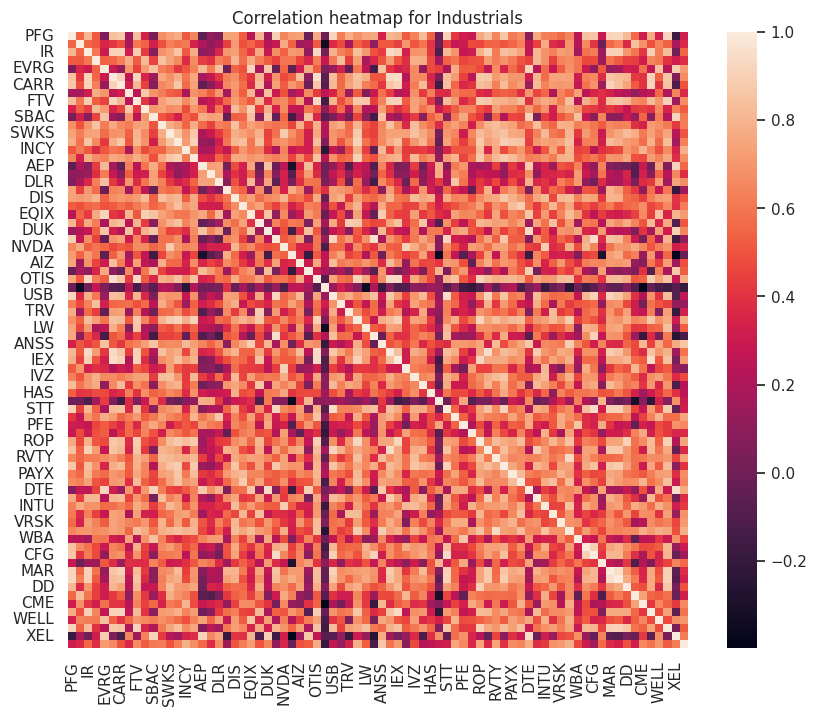

In [92]:
sns.heatmap(sector_corr_matrices['Industrials']).set_title("Correlation heatmap for Industrials")

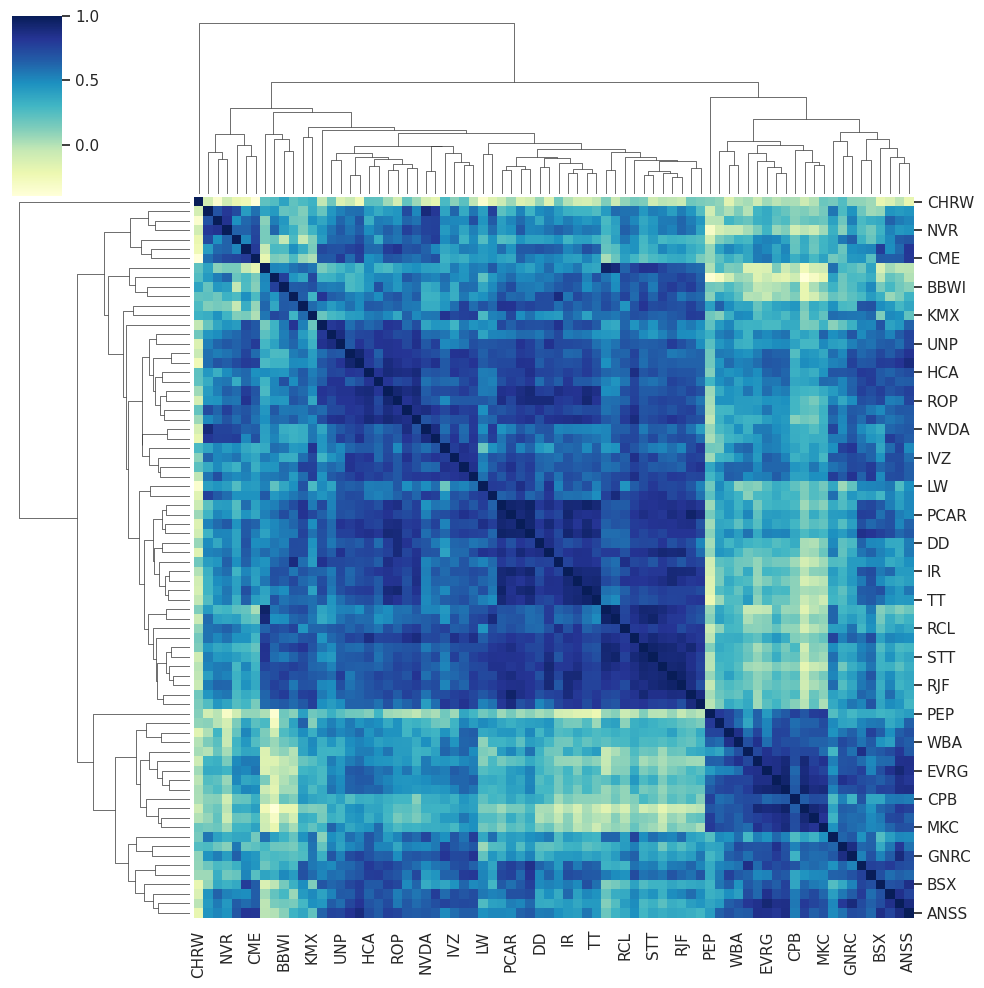

In [94]:
sns.clustermap(sector_corr_matrices['Industrials'], cmap="YlGnBu")
plt.show()

In [93]:
sector_corr_matrices['Industrials']

,PFG,TTWO,IR,F,EVRG,XYL,CARR,LOW,FTV,GNRC,...,MAR,RJF,DD,NVR,CME,TT,WELL,IPG,XEL,BSX
PFG,1.000000,0.550955,0.810739,0.514796,0.051721,0.846562,0.867299,0.168224,0.830817,0.337144,...,0.917347,0.925843,0.817579,0.562106,0.309467,0.770287,0.331911,0.917504,-0.182961,0.311925
TTWO,0.550955,1.000000,0.544180,0.510523,0.354230,0.413910,0.485525,0.177505,0.606151,0.538235,...,0.553487,0.626580,0.369915,0.831293,0.678596,0.490634,0.638462,0.536461,0.181500,0.362142
IR,0.810739,0.544180,1.000000,0.602077,0.295322,0.911107,0.910492,0.316260,0.890256,0.427240,...,0.904608,0.900965,0.696475,0.597527,0.411659,0.891782,0.616846,0.829101,-0.009492,0.555228
F,0.514796,0.510523,0.602077,1.000000,0.538520,0.547522,0.624992,0.772506,0.519340,0.818964,...,0.589385,0.516864,0.445676,0.433912,0.322125,0.649498,0.603833,0.397153,0.313921,0.378075
EVRG,0.051721,0.354230,0.295322,0.538520,1.000000,0.299505,0.135490,0.698429,0.438116,0.713278,...,0.132654,0.179082,0.314075,0.311619,0.576199,0.272760,0.842564,0.233349,0.886792,0.712563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT,0.770287,0.490634,0.891782,0.649498,0.272760,0.908398,0.917231,0.266124,0.822867,0.406145,...,0.756053,0.760567,0.764757,0.550447,0.413595,1.000000,0.468171,0.734523,-0.063605,0.588895
WELL,0.331911,0.638462,0.616846,0.603833,0.842564,0.539123,0.402072,0.562697,0.701345,0.660634,...,0.483138,0.513829,0.363918,0.527029,0.655649,0.468171,1.000000,0.472314,0.670996,0.697830
IPG,0.917504,0.536461,0.829101,0.397153,0.233349,0.868206,0.848641,0.213067,0.906524,0.352164,...,0.898880,0.909897,0.866893,0.584785,0.531642,0.734523,0.472314,1.000000,0.029886,0.530105
XEL,-0.182961,0.181500,-0.009492,0.313921,0.886792,0.051117,-0.117187,0.647585,0.148922,0.633737,...,-0.067784,-0.082874,0.025611,-0.017824,0.417581,-0.063605,0.670996,0.029886,1.000000,0.620888


### Health Care

Text(0.5, 1.0, 'Correlation heatmap for Health Care')

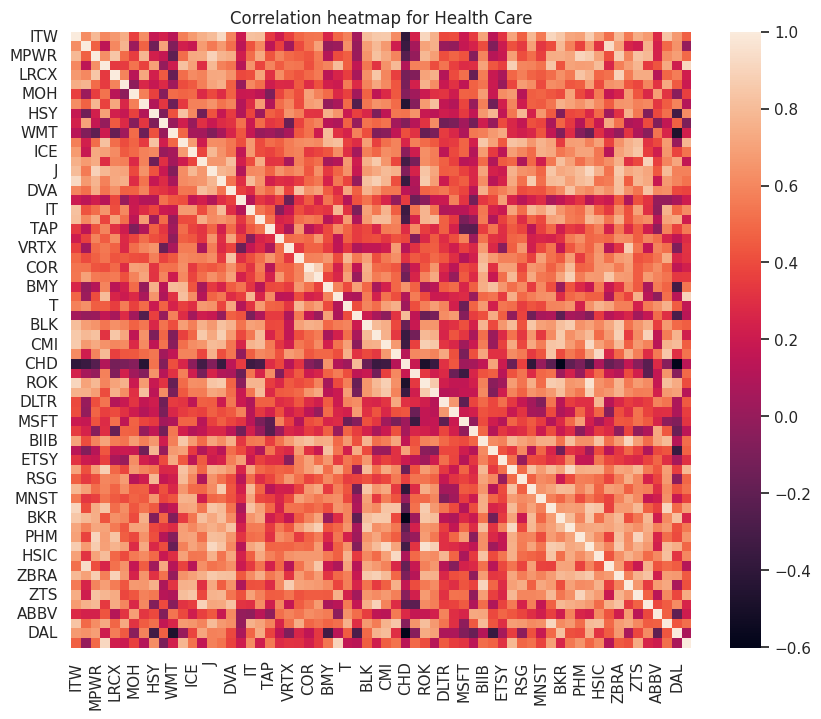

In [173]:
sns.heatmap(sector_corr_matrices['Health Care']).set_title("Correlation heatmap for Health Care")

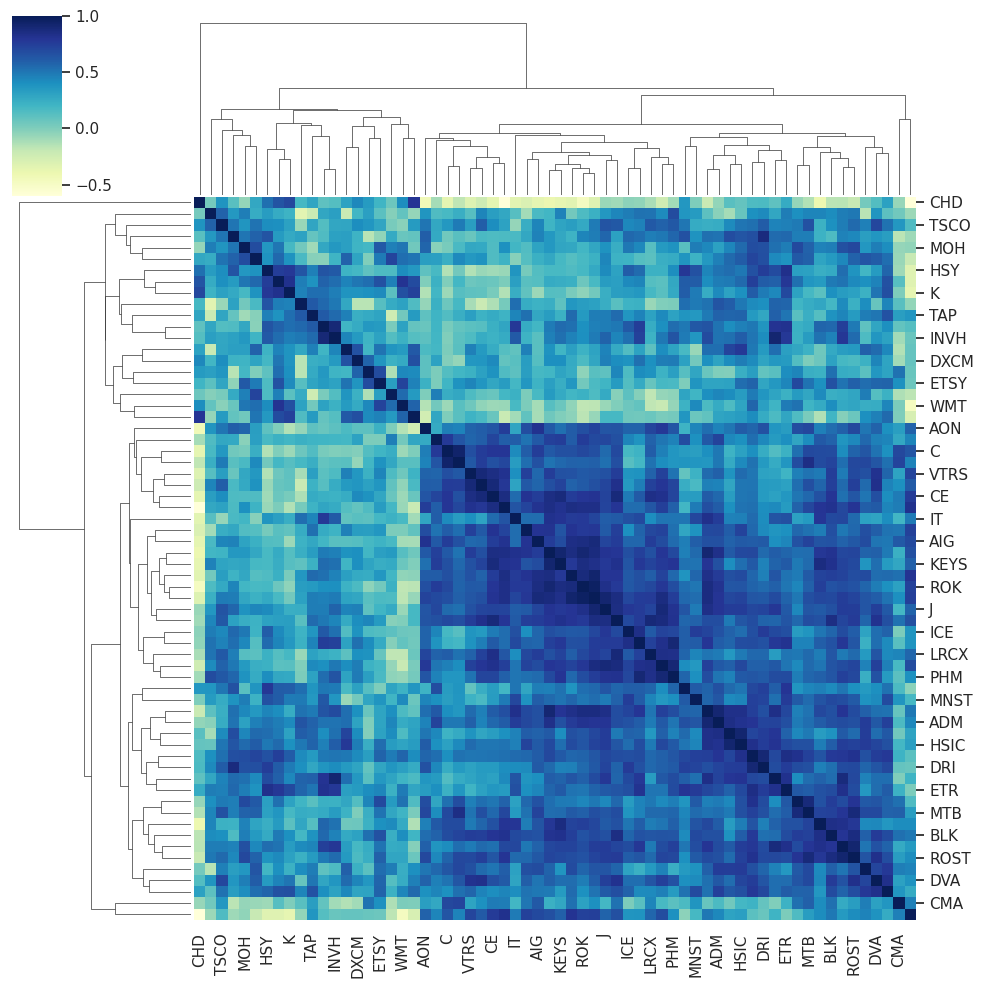

In [183]:
sns.clustermap(sector_corr_matrices['Health Care'], cmap="YlGnBu")
plt.show()


### Information Technology

In [ ]:
sns.heatmap(sector_corr_matrices['Information Technology']).set_title("Correlation heatmap for Information Technology")

In [ ]:
sns.clustermap(sector_corr_matrices['Information Technology'])
plt.show()

### Consumer Staples

In [ ]:
sns.heatmap(sector_corr_matrices['Consumer Staples']).set_title("Correlation heatmap for Consumer Staples")

### Communication Services

In [ ]:
sns.heatmap(sector_corr_matrices['Communication Services']).set_title("Correlation heatmap for Communication Services")

### Utilities

In [ ]:
sns.heatmap(sector_corr_matrices['Utilities']).set_title("Correlation heatmap for Utilities")

### Financials

In [ ]:
sns.heatmap(sector_corr_matrices['Financials']).set_title("Correlation heatmap for Financials")

### Consumer Discretionary

In [ ]:
sns.heatmap(sector_corr_matrices['Consumer Discretionary']).set_title("Correlation heatmap for Consumer  Discretionary")

### Materials

In [ ]:
sns.heatmap(sector_corr_matrices['Materials']).set_title("Correlation heatmap for Materials")

### Real Estate

In [ ]:
sns.heatmap(sector_corr_matrices['Real Estate']).set_title("Correlation heatmap for Real Estate")

### Energy

In [ ]:
sns.heatmap(sector_corr_matrices['Energy']).set_title("Correlation heatmap for Energy")

## Price Change Scatter Plots

In [130]:
# creates a df version of the correlation values
df_corr = {}
for sectors, matrix in sector_corr_matrices.items():
  df_name = f'df_{sectors}'
  df_corr[df_name] = matrix.corr().stack().reset_index(name='correlation')

print(df_corr['df_Industrials'])

     level_0 level_1  correlation
0        PFG     PFG     1.000000
1        PFG    TTWO     0.491703
2        PFG      IR     0.899484
3        PFG       F     0.303639
4        PFG    EVRG    -0.700603
...      ...     ...          ...
5771     BSX      TT     0.173863
5772     BSX    WELL     0.724698
5773     BSX     IPG     0.085708
5774     BSX     XEL     0.568818
5775     BSX     BSX     1.000000

[5776 rows x 3 columns]


### Comparing correlation values

In [141]:
df_price_pct

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,average
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745,0.013507
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218,-0.004392
2023-03-07,-0.020247,0.014888,-0.014497,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560,-0.015829
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639,0.002340
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015594,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819,-0.020040
2023-03-10,-0.023105,-0.026448,-0.013879,0.016016,-0.012850,-0.009096,-0.025885,-0.026217,-0.026805,-0.009806,...,-0.016031,-0.012371,-0.004314,-0.014928,-0.011662,0.009644,-0.029369,-0.024420,-0.035584,-0.020058
2023-03-13,0.007147,-0.039457,0.013266,0.014962,-0.019780,0.012686,-0.021468,-0.006484,-0.015275,0.004346,...,0.032901,-0.011505,0.016789,-0.010911,0.002488,0.005828,-0.011347,-0.257249,0.011639,-0.008658
2023-03-14,0.012510,-0.012795,0.014089,0.012504,0.003449,0.003666,0.033139,0.004656,0.027940,0.022076,...,0.010188,0.003754,0.015446,0.020429,0.014493,0.019155,0.026463,0.044711,0.007038,0.013898
2023-03-15,-0.031575,-0.054570,0.002621,0.001365,-0.023891,-0.007610,-0.068310,-0.024992,0.000840,-0.019563,...,0.028576,-0.049747,-0.024128,-0.033534,0.003394,-0.010819,-0.016139,-0.019163,-0.006016,-0.014876
2023-03-16,0.020816,0.018759,0.018694,0.008049,0.056436,0.012577,0.053076,0.027420,0.058991,0.020226,...,-0.001040,-0.005806,0.006181,0.006318,0.007315,0.001357,0.024988,0.045588,0.016751,0.013741


In [151]:
df_CPB = df_price_pct['CPB']
df_CPB

2023-03-03   -0.000191
2023-03-06    0.003244
2023-03-07   -0.008558
2023-03-08    0.019375
2023-03-09   -0.015243
2023-03-10    0.003440
2023-03-13    0.014664
2023-03-14    0.009197
2023-03-15    0.010601
2023-03-16   -0.005153
2023-03-17   -0.012579
2023-03-20    0.013114
Name: CPB, dtype: float64

In [152]:
df_AEP = df_price_pct['AEP']
df_AEP

2023-03-03    0.012501
2023-03-06    0.003143
2023-03-07   -0.008280
2023-03-08    0.007560
2023-03-09   -0.006047
2023-03-10   -0.013858
2023-03-13    0.021136
2023-03-14    0.009734
2023-03-15    0.025928
2023-03-16   -0.006264
2023-03-17   -0.014238
2023-03-20    0.011687
Name: AEP, dtype: float64

AEP is a American Electric Power while CPB is Central Pacific Bank which is a private nonprofit bank created by the US for public broadcasting. Their correlation is nagative

In [156]:
price_corr.loc['AEP', 'CPB']

0.7244992411598944

In [150]:
import plotly.express as px

fig2 = px.scatter(x=df_CPB,
                  y = df_AEP)
fig2.show()

In [153]:
fig3 = px.scatter(x = df_price_pct['XEL'],
                  y = df_price_pct['DTE'])

fig3.show()

In [159]:
print(df_corr['df_Industrials']['correlation'].unique())

[ 1.          0.49170262  0.8994835  ... -0.66401445  0.08570757
  0.56881803]


In [158]:


filtered_df = df_corr['df_Industrials'][(df_corr['df_Industrials']['correlation'] >= 0.9) | (df_corr['df_Industrials']['correlation'] <= -0.9)]

fig = px.scatter_3d(filtered_df,
                    x = 'level_0',
                    y = 'level_1',
                    z = 'correlation',
                    color = 'correlation')

fig.update_layout(
    scene = dict(
        xaxis=dict(title='Company 1'),
        yaxis=dict(title='Company 2'),
        zaxis=dict(title='Correlation'),
  ),
    title='3D Scatter Plot of Correlation Values for the Industrials Sector'
)

fig.show()

In [163]:
print(filtered_df['correlation'].unique)

<bound method Series.unique of 0       1.000000
6       0.939828
25      0.939263
32      0.964245
43      0.917133
          ...   
5648    0.955222
5653    0.963531
5680    0.980293
5698    1.000000
5775    1.000000
Name: correlation, Length: 358, dtype: float64>


## Creating hiearchial clustering with 3d scatter plots

In [169]:
# Assuming df_corr['df_Industrials']['correlation'] contains correlation values
correlation_values = df_corr['df_Industrials']['correlation']

# Convert the correlation values to a 2D array
correlation_matrix = correlation_values.values.reshape(-1, 1)

# Convert the correlation matrix to a condensed distance matrix
distances = pdist(correlation_matrix)

# Perform hierarchical clustering
linked = linkage(distances, 'average')

# Set a distance threshold for forming clusters
dist_thresh = 0.2
clusters = fcluster(linked, dist_thresh, criterion='distance')

# Assign cluster information to the DataFrame
df_corr['df_Industrials']['Cluster'] = clusters

# Get the leaves of the hierarchical clustering tree
leaves = dendrogram(linked, no_plot=True)['leaves']

# Create a 3D scatter plot
fig4 = px.scatter_3d(df_corr['df_Industrials'].iloc[leaves].reset_index(),
                     x='level_0',
                     y='level_1',
                     z='correlation',
                     color='Cluster')

fig4.update_layout(scene=dict(
    xaxis=dict(title='Company 1'),
    yaxis=dict(title='Company 2'),
    zaxis=dict(title='Correlation'),
), title='Hierarchical Clustering 3D Scatter Plot')

fig4.show()


In [ ]:
from scipy.spatial.distance import pdist, squareform

#calculating distances for correlation
def calculate_dist_matrix(df_price_pct):
  dist_pct = pdist(df_price_pct.T, metric = 'euclidean')
  return squareform(dist)

# Create the 3D scatter plot
def create_3d(x, y, z):
  fig = go.Figure(data=[go.Scatter3d(
    x=df_price_pct.columns,
    y=df_price_pct.columns,
    z=dist_matrix_pct,
    mode='markers',
    marker=dict(size=4),
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Companies'),
        yaxis=dict(title='Companies'),
        zaxis=dict(title='Distance (Correlation)'),
    ),
    title='3D Correlation Graph using Distance Formula',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [ ]:
df_price_pct